In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import uuid
import warnings
warnings.filterwarnings('ignore')

# Load the dataset (replace 'your_data.csv' with your actual file path)
data = pd.read_excel('/kaggle/input/newversionwithoutdataleakage/Data for Item Proposal_Regional-1.xlsx',sheet_name="Raw Data")
data.columns=data.columns.str.replace(" ","_")
# Display basic info to understand the data
print(data.head())
print(data.info())

       Month   Zone_Name    Depot  Item_Code Item_Name       Category  \
0 2024-02-01    Rajshahi  Depot-3     424877    RedT-8       Red Tube   
1 2024-02-01    Rajshahi  Depot-3     424806   Rtyre-8  Rickshaw Tyre   
2 2024-02-01    Rajshahi  Depot-3     424827  Btyre-53   Bicycle Tyre   
3 2024-02-01    Rajshahi  Depot-3     424787  Btyre-41   Bicycle Tyre   
4 2024-02-01  Mymensingh  Depot-1     424772   Rtyre-7  Rickshaw Tyre   

   Unit_Price    Sales  Sales_Qty  Net_Discount  Net_Sales  
0       148.0  37000.0      250.0        2960.0    34040.0  
1       576.0  11520.0       20.0         806.0    10714.0  
2       250.0   2500.0       10.0         175.0     2325.0  
3       270.0   2700.0       10.0         297.0     2403.0  
4       576.0  11520.0       20.0         922.0    10598.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12522 entries, 0 to 12521
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -

In [18]:
# Handle missing values
data.fillna({'Unit_Price': data['Unit_Price'].mean(), 
             'Sales_Qty': data['Sales_Qty'].mean(), 
             'Net_Discount': 0}, inplace=True)

# Encode categorical features
categorical_cols = ['Zone_Name', 'Depot', 'Item_Name', 'Category']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col + '_encoded'] = le.fit_transform(data[col])
    label_encoders[col] = le

# Sort data by Month to ensure temporal order (assuming Month is a string like 'Jan-2025')
# Convert Month to a datetime-like format if possible
data['Month'] = pd.to_datetime(data['Month'], format='%b-%Y', errors='coerce')
data.sort_values('Month', inplace=True)

# Define feature columns (excluding target and original categorical columns)
feature_cols = ['Unit_Price', 'Sales_Qty', 'Net_Discount'] + [col + '_encoded' for col in categorical_cols]
target_col = 'Net_Sales'

# Verify data
print(data[feature_cols + [target_col]].head())

      Unit_Price  Sales_Qty  Net_Discount  Zone_Name_encoded  Depot_encoded  \
1332       280.0       50.0         910.0                  0              4   
1064       576.0      420.0       14515.0                 10              0   
1063       576.0      120.0        4147.0                 10              0   
1062       148.0     1150.0       12765.0                 10              0   
1061       148.0      400.0        4440.0                 10              0   

      Item_Name_encoded  Category_encoded  Net_Sales  
1332                 52                 1    13090.0  
1064                 98                 4   227405.0  
1063                 98                 4    64973.0  
1062                 85                 2   157435.0  
1061                 85                 2    54760.0  


In [20]:
def create_lag_features(df, group_col, value_col, lags=[1, 2, 3, 7]):
    """
    Create lag features for a given column within groups, ensuring no data leakage.
    
    Parameters:
    - df: DataFrame sorted by time
    - group_col: Column to group by (e.g., 'Item Code')
    - value_col: Column to create lags for (e.g., 'Net Sales')
    - lags: List of lag periods
    """
    df = df.copy()
    for lag in lags:
        df[f'{value_col}_lag_{lag}'] = df.groupby(group_col)[value_col].shift(lag)
    return df

# Create lag features for Net Sales
data = create_lag_features(data, group_col='Item_Code', value_col='Net_Sales', lags=[1, 2, 3, 7])

# Drop rows with NaN values in lag features
data.dropna(subset=[f'Net_Sales_lag_{lag}' for lag in [1, 2, 3, 7]], inplace=True)

# Update feature columns to include lag features
lag_features = [f'Net_Sales_lag_{lag}' for lag in [1, 2, 3, 7]]
feature_cols += lag_features

# Verify lag features
print(data[feature_cols + [target_col]].head())

      Unit_Price  Sales_Qty  Net_Discount  Zone_Name_encoded  Depot_encoded  \
1007       135.0       50.0         338.0                 10              0   
1001        92.0       50.0         230.0                 10              0   
1000        92.0       25.0         115.0                 10              0   
999         92.0      100.0         460.0                 10              0   
997         78.0      100.0         390.0                 10              0   

      Item_Name_encoded  Category_encoded  Net_Sales_lag_1  Net_Sales_lag_2  \
1007                  8                 0           6480.0          12825.0   
1001                  9                 0           6412.0           6480.0   
1000                  9                 0           4370.0           6412.0   
999                   9                 0           2185.0           4370.0   
997                  13                 0           3744.0          26125.0   

      Net_Sales_lag_3  Net_Sales_lag_7  Net_Sales 

In [21]:
# Calculate split index (80% train, 20% test)
split_idx = int(len(data) * 0.8)

# Split data temporally
train_data = data.iloc[:split_idx]
test_data = data.iloc[split_idx:]

# Separate features and target
X_train = train_data[feature_cols]
y_train = train_data[target_col]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

# Verify shapes
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (9652, 11), (9652,)
Testing set shape: (2414, 11), (2414,)


In [22]:
# Define models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'CatBoostRegressor': CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, verbose=0, random_state=42),
    'LGBMRegressor': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'XGBRegressor': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MSE': mse, 'R2': r2}
    
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

# Display results
print("\nModel Performance Summary:")
for name, metrics in results.items():
    print(f"{name}: MSE = {metrics['MSE']:.4f}, R2 = {metrics['R2']:.4f}")

LinearRegression - MSE: 319265194.8385, R2: 0.9603
RandomForestRegressor - MSE: 140979483.1849, R2: 0.9825
CatBoostRegressor - MSE: 368186455.6653, R2: 0.9542
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1874
[LightGBM] [Info] Number of data points in the train set: 9652, number of used features: 11
[LightGBM] [Info] Start training from score 28201.221923
LGBMRegressor - MSE: 582785010.7341, R2: 0.9275
XGBRegressor - MSE: 944537182.5299, R2: 0.8824

Model Performance Summary:
LinearRegression: MSE = 319265194.8385, R2 = 0.9603
RandomForestRegressor: MSE = 140979483.1849, R2 = 0.9825
CatBoostRegressor: MSE = 368186455.6653, R2 = 0.9542
LGBMRegressor: MSE = 582785010.7341, R2 = 0.9275
XGBRegressor: MSE = 944537182.5299, R2 = 0.8824


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Initialize results dictionary for additional metrics
extended_results = {name: {'MSE': metrics['MSE'], 'R2': metrics['R2']} for name, metrics in results.items()}

# Calculate additional metrics and store predictions
model_predictions = {}
for name, model in models.items():
    # Predict on test set (already done in previous chunk, recomputing for clarity)
    y_pred = model.predict(X_test)
    model_predictions[name] = y_pred
    
    # Calculate additional metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100  # Convert to percentage
    
    # Update results
    extended_results[name].update({'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

# Convert results to DataFrame for visualization
results_df = pd.DataFrame(extended_results).T
print("\nExtended Model Performance Summary:")
print(results_df)




Extended Model Performance Summary:
                                MSE        R2          MAE          RMSE  \
LinearRegression       3.192652e+08  0.960262  5546.397940  17867.993587   
RandomForestRegressor  1.409795e+08  0.982453  1955.904544  11873.478142   
CatBoostRegressor      3.681865e+08  0.954173  4620.619873  19188.185315   
LGBMRegressor          5.827850e+08  0.927462  3114.461435  24140.940552   
XGBRegressor           9.445372e+08  0.882435  3745.595782  30733.323649   

                            MAPE  
LinearRegression       23.764228  
RandomForestRegressor   2.355596  
CatBoostRegressor      19.357880  
LGBMRegressor           6.196872  
XGBRegressor            7.376749  


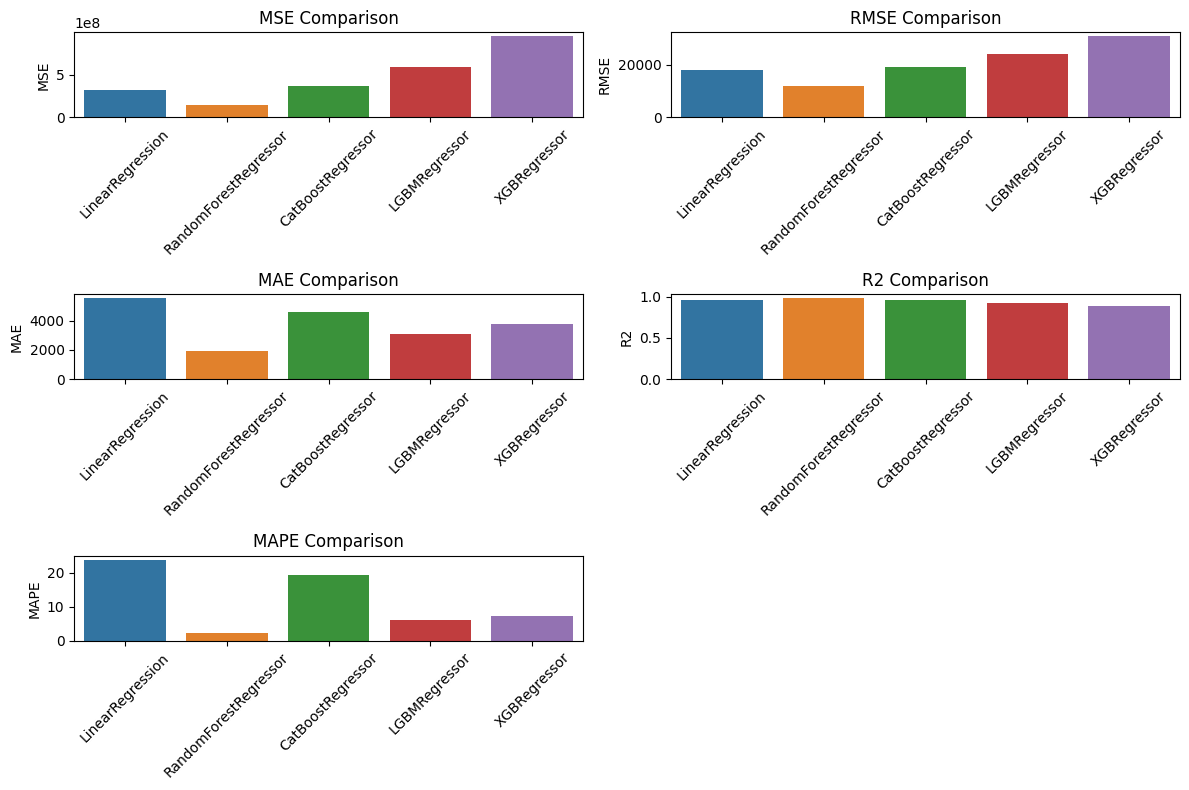

In [24]:
# Plot 1: Bar plot for metrics comparison
plt.figure(figsize=(12, 8))
metrics = ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x=results_df.index, y=results_df[metric])
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    plt.ylabel(metric)
plt.tight_layout()
plt.show()



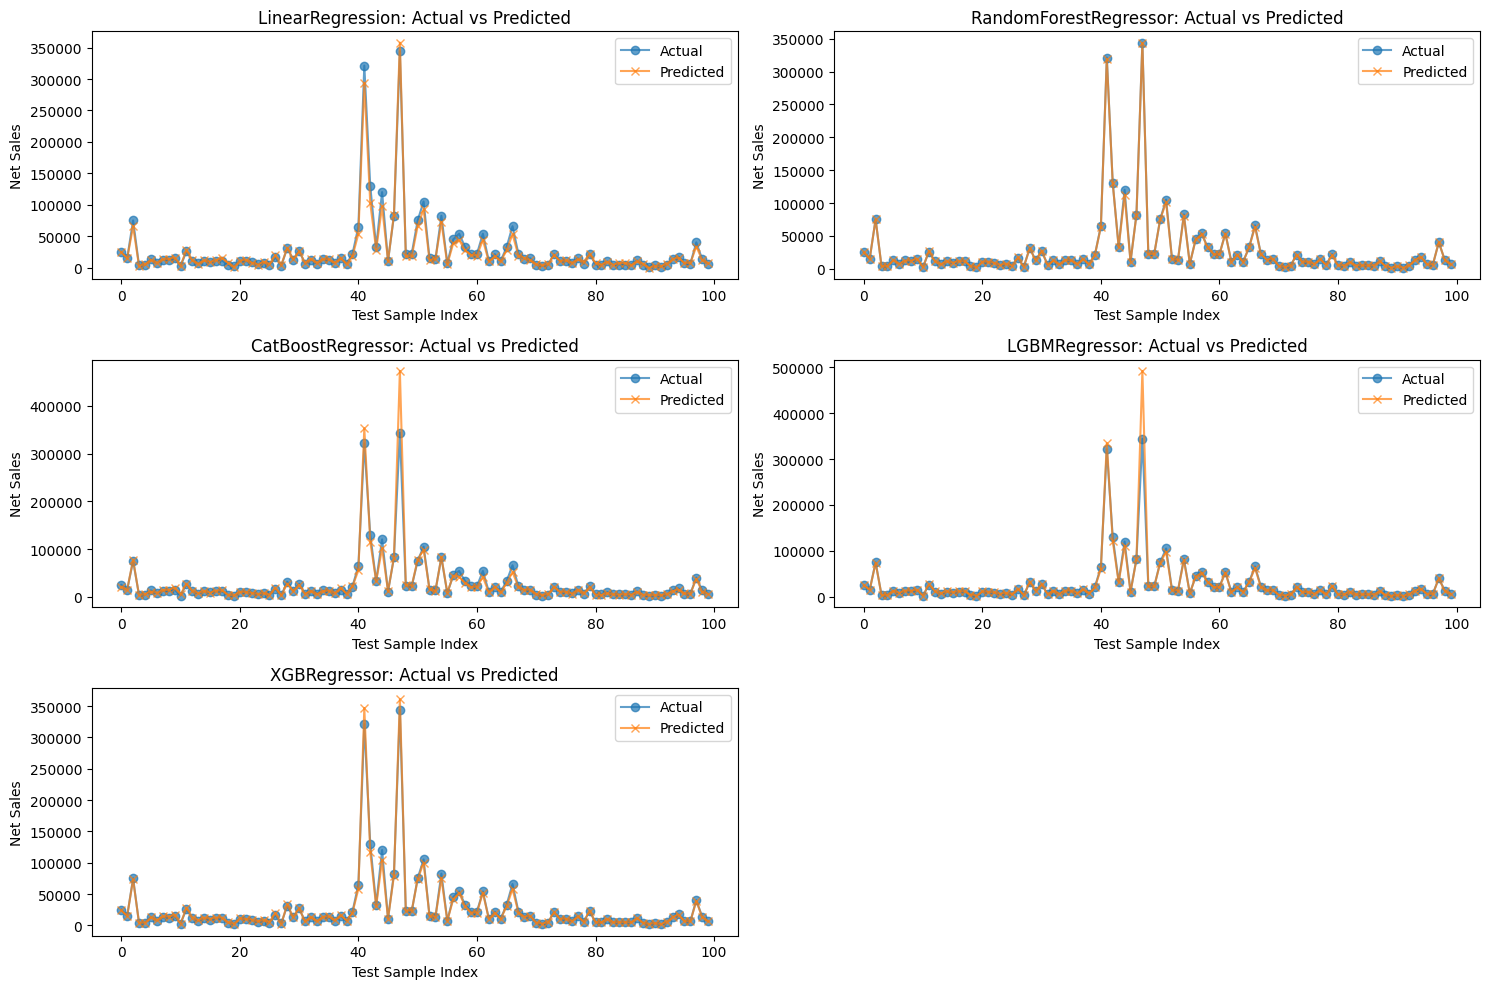

In [25]:
# Plot 2: Actual vs Predicted line plots
plt.figure(figsize=(15, 10))
for i, (name, y_pred) in enumerate(model_predictions.items(), 1):
    plt.subplot(3, 2, i)
    plt.plot(y_test.values[:100], label='Actual', marker='o', alpha=0.7)
    plt.plot(y_pred[:100], label='Predicted', marker='x', alpha=0.7)
    plt.title(f'{name}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel('Net Sales')
    plt.legend()
plt.tight_layout()
plt.show()

In [26]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Initialize results dictionary for training and test metrics
overfit_results = {}

for name, model in models.items():
    # Training set predictions
    y_train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100

    # Test set predictions (recompute for consistency)
    y_test_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

    # Store results
    overfit_results[name] = {
        'Train_MSE': train_mse,
        'Test_MSE': test_mse,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Train_MAPE': train_mape,
        'Test_MAPE': test_mape
    }

# Convert to DataFrame for easy comparison
overfit_df = pd.DataFrame(overfit_results).T
print("\nTraining vs Test Performance Comparison:")
print(overfit_df)

# Highlight potential overfitting
for model in overfit_results:
    print(f"\n{model} Analysis:")
    if overfit_results[model]['Train_R2'] > overfit_results[model]['Test_R2'] + 0.05:
        print(f"Possible overfitting: Train R2 ({overfit_results[model]['Train_R2']:.4f}) "
              f"> Test R2 ({overfit_results[model]['Test_R2']:.4f})")
    elif overfit_results[model]['Test_R2'] > overfit_results[model]['Train_R2']:
        print("Underfitting: Test R2 higher than Train R2")
    else:
        print("Balanced performance: Train and Test R2 are close")


Training vs Test Performance Comparison:
                          Train_MSE      Test_MSE    Train_RMSE     Test_RMSE  \
LinearRegression       1.082319e+08  3.192652e+08  10403.456501  17867.993587   
RandomForestRegressor  1.153561e+07  1.409795e+08   3396.411661  11873.478142   
CatBoostRegressor      3.702799e+07  3.681865e+08   6085.063126  19188.185315   
LGBMRegressor          1.452912e+08  5.827850e+08  12053.678485  24140.940552   
XGBRegressor           6.026910e+06  9.445372e+08   2454.976632  30733.323649   

                         Train_MAE     Test_MAE  Train_R2   Test_R2  \
LinearRegression       4086.617994  5546.397940  0.975072  0.960262   
RandomForestRegressor   452.775877  1955.904544  0.997343  0.982453   
CatBoostRegressor      2907.144085  4620.619873  0.991472  0.954173   
LGBMRegressor          1437.711181  3114.461435  0.966536  0.927462   
XGBRegressor           1216.816827  3745.595782  0.998612  0.882435   

                       Train_MAPE  Test_MAPE

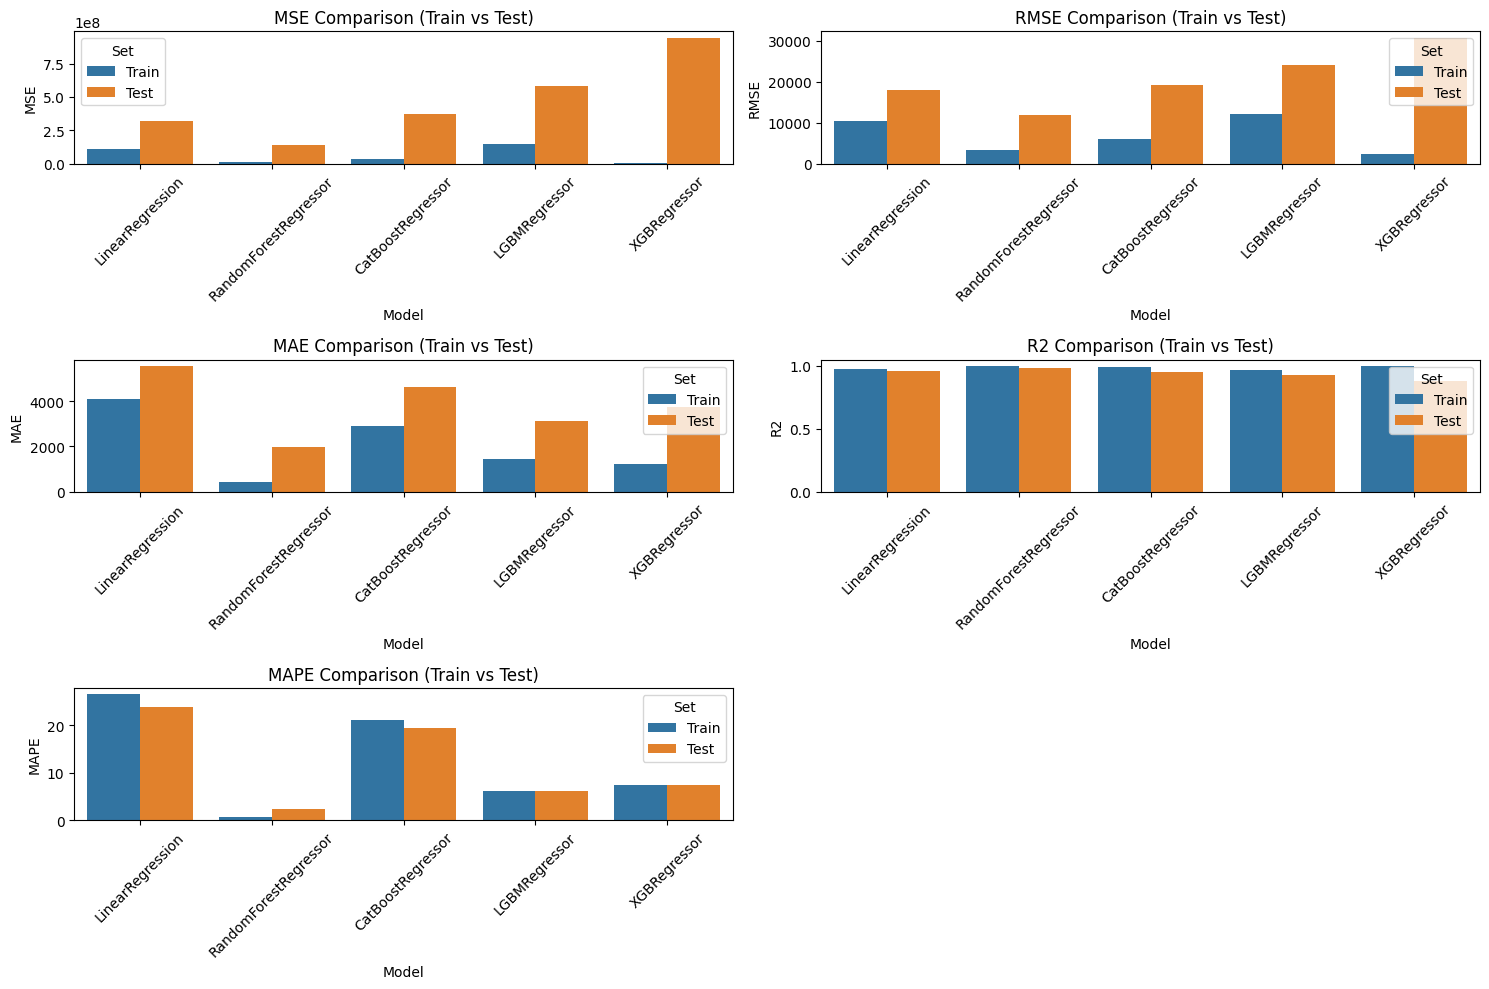

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert overfit_results to a plotting-friendly format
plot_data = []
for model, metrics in overfit_results.items():
    for metric in ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']:
        plot_data.append({
            'Model': model,
            'Metric': metric,
            'Train': metrics[f'Train_{metric}'],
            'Test': metrics[f'Test_{metric}']
        })
plot_df = pd.DataFrame(plot_data)

# Plot training vs test metrics
plt.figure(figsize=(15, 10))
metrics = ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    metric_data = plot_df[plot_df['Metric'] == metric]
    melted = pd.melt(metric_data, id_vars=['Model', 'Metric'], value_vars=['Train', 'Test'], var_name='Set', value_name=metric)
    sns.barplot(x='Model', y=metric, hue='Set', data=melted)
    plt.title(f'{metric} Comparison (Train vs Test)')
    plt.xticks(rotation=45)
    plt.ylabel(metric)
plt.tight_layout()
plt.show()

In [28]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

# Define parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100],
    'min_child_weight': [1, 3],
    'reg_lambda': [0.1, 1.0]
}

# Initialize TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize XGBoost model
xgb = XGBRegressor(random_state=42)

# Perform grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_xgb = grid_search.best_estimator_
print("Best XGBoost Parameters:", grid_search.best_params_)

# Evaluate best model
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Compute metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred) * 100
test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100

print("\nTuned XGBoost Performance:")
print(f"Train MSE: {train_mse:.4e}, Test MSE: {test_mse:.4e}")
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train MAE: {train_mae:.2f}, Test MAE: {test_mae:.2f}")
print(f"Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")
print(f"Train MAPE: {train_mape:.2f}%, Test MAPE: {test_mape:.2f}%")

Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_lambda': 0.1}

Tuned XGBoost Performance:
Train MSE: 3.6569e+07, Test MSE: 2.2347e+08
Train RMSE: 6047.22, Test RMSE: 14948.89
Train MAE: 2467.47, Test MAE: 3880.80
Train R2: 0.9916, Test R2: 0.9722
Train MAPE: 14.05%, Test MAPE: 12.38%


In [30]:
# after fune tuned

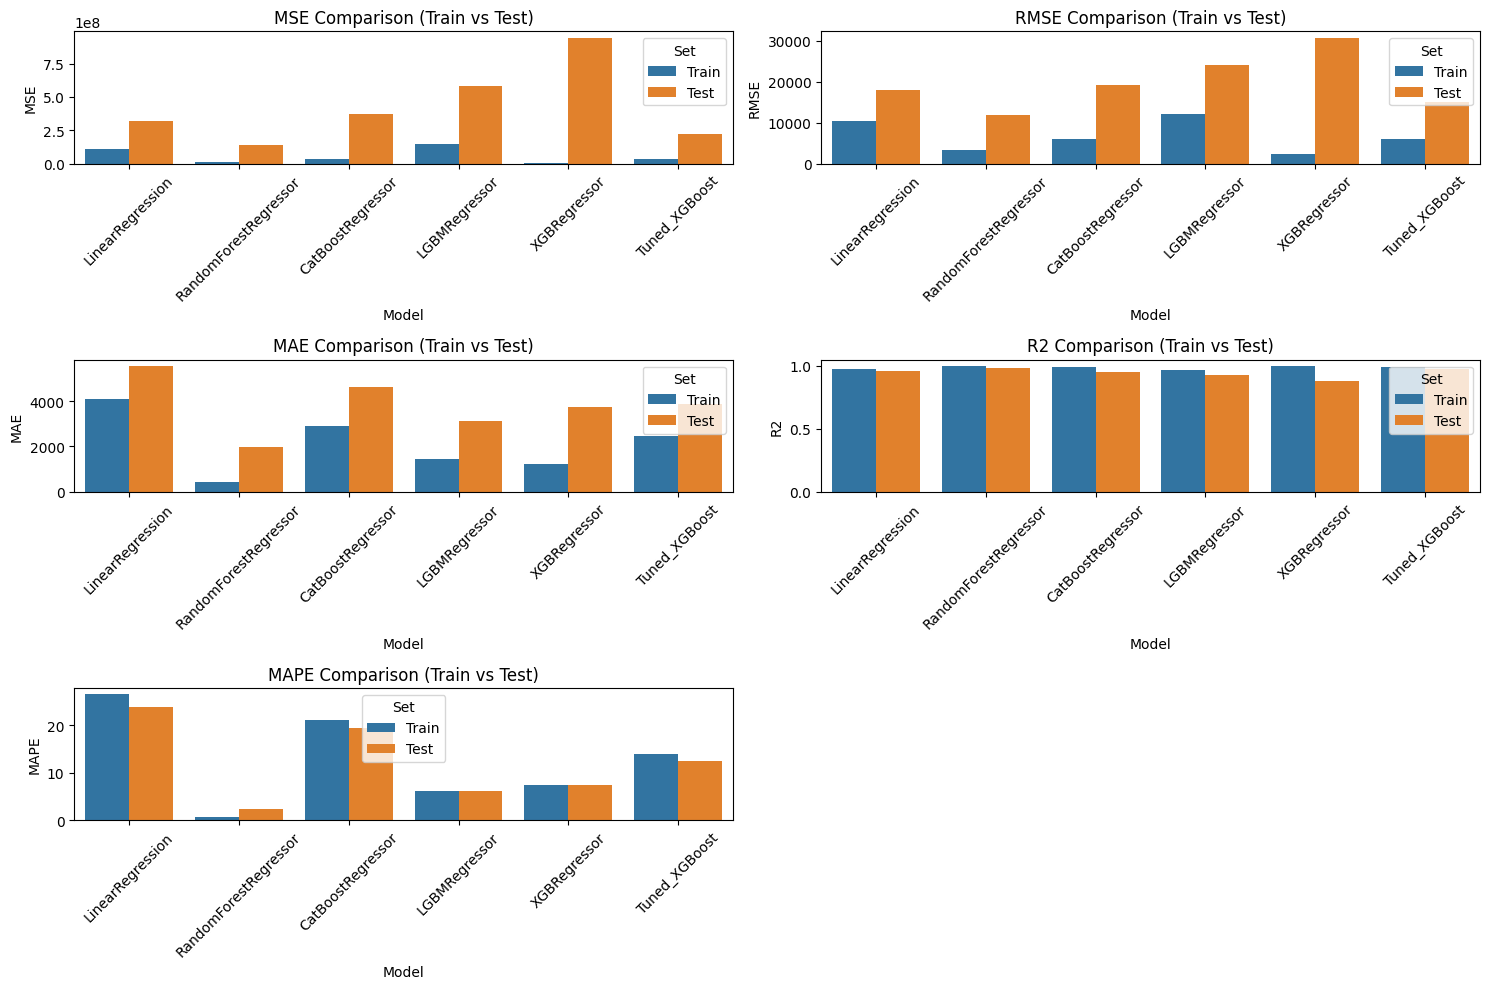

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Update overfit_results with tuned XGBoost metrics
overfit_results['Tuned_XGBoost'] = {
    'Train_MSE': 3.6569e+07,
    'Test_MSE': 2.2347e+08,
    'Train_RMSE': 6047.22,
    'Test_RMSE': 14948.89,
    'Train_MAE': 2467.47,
    'Test_MAE': 3880.80,
    'Train_R2': 0.9916,
    'Test_R2': 0.9722,
    'Train_MAPE': 14.05,
    'Test_MAPE': 12.38
}

# Convert overfit_results to a plotting-friendly format
plot_data = []
for model, metrics in overfit_results.items():
    for metric in ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']:
        plot_data.append({
            'Model': model,
            'Metric': metric,
            'Train': metrics[f'Train_{metric}'],
            'Test': metrics[f'Test_{metric}']
        })
plot_df = pd.DataFrame(plot_data)

# Plot training vs test metrics
plt.figure(figsize=(15, 10))
metrics = ['MSE', 'RMSE', 'MAE', 'R2', 'MAPE']
for i, metric in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    metric_data = plot_df[plot_df['Metric'] == metric]
    melted = pd.melt(metric_data, id_vars=['Model', 'Metric'], value_vars=['Train', 'Test'], var_name='Set', value_name=metric)
    sns.barplot(x='Model', y=metric, hue='Set', data=melted)
    plt.title(f'{metric} Comparison (Train vs Test)')
    plt.xticks(rotation=45)
    plt.ylabel(metric)
plt.tight_layout()
plt.show()